In [ ]:
#ディリクレ過程を使ったクラスタリングの基本プログラム
#2021年1月21日から多次元に拡張して作成

In [ ]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle
import copy

In [1059]:
initial_data_dim = 10
real_cluster_number =5
center_std = 3
data_std = 1.5
N_data_one_cluster =100

In [1060]:
#n次元中の中心を決める
cluster_centers = center_std*np.random.randn(real_cluster_number,initial_data_dim)
distribution = data_std*np.random.randn(N_data_one_cluster,real_cluster_number,initial_data_dim)
distribution.shape,np.repeat(cluster_centers[None,:],N_data_one_cluster,axis=0).shape
X_data = distribution+np.repeat(cluster_centers[None,:],N_data_one_cluster,axis=0)
ts =np.repeat(np.arange(real_cluster_number),N_data_one_cluster)

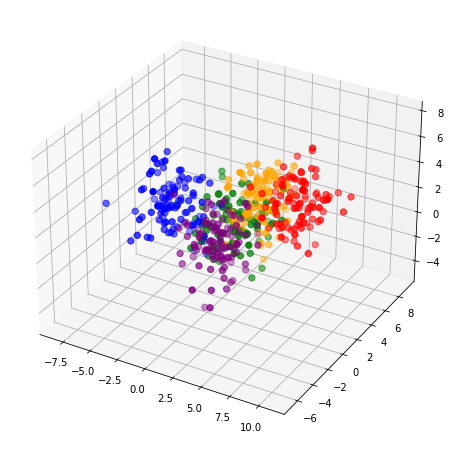

In [1061]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data[:,0,0], X_data[:,0,1], X_data[:,0,2], s = 40, c = "blue")
ax.scatter(X_data[:,1,0], X_data[:,1,1], X_data[:,1,2], s = 40, c = "red")
ax.scatter(X_data[:,2,0], X_data[:,2,1], X_data[:,2,2], s = 40, c = "green")
ax.scatter(X_data[:,3,0], X_data[:,3,1], X_data[:,3,2], s = 40, c = "purple")
ax.scatter(X_data[:,4,0], X_data[:,4,1], X_data[:,4,2], s = 40, c = "orange")

In [1062]:
X_data_concat = X_data[:,0,:]
for i in range(1,X_data.shape[1]):
    X_data_concat = np.concatenate([X_data_concat,X_data[:,i,:]],axis=0)
X_data_concat.shape

(500, 10)

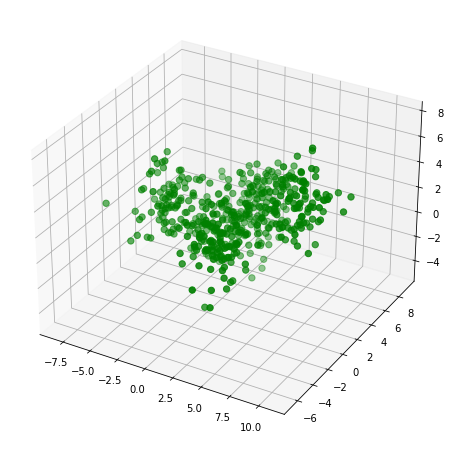

In [1063]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data_concat[:,0], X_data_concat[:,1], X_data_concat[:,2], s = 40, c = "green")
plt.show()

In [1064]:
random_label = np.random.permutation(np.arange(X_data_concat.shape[0]))
X_2d_p_data = X_data_concat[random_label]
ts_p_data = ts[random_label]

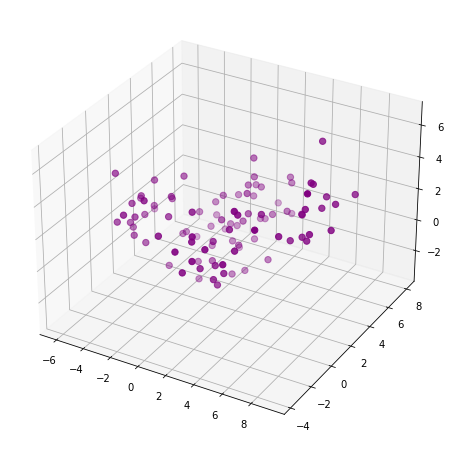

In [1065]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2d_p_data[:100,0], X_2d_p_data[:100,1], X_2d_p_data[:100,2], s = 40, c = "purple")
plt.show()

In [1007]:
def log_P_func(l_f,latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    cluster_data = latent_data_f[l_f]
    cluster_center = cluster_data.mean(axis=0)
    n_prime = len(l_f)
    mu_c = (n_prime*cluster_center+pre_beta_f*pre_mu_0_f)/(n_prime+pre_beta_f)
#    mu_c = n_prime*cluster_center
#    mu_c +=pre_beta_f*pre_mu_0_f
#    mu_c/=(n_prime+pre_beta_f)

    S_q_inv = S_0_inv_f + n_prime*np.cov(cluster_data,rowvar=0,bias=1) + n_prime*pre_beta_f*np.outer(cluster_center-pre_mu_0_f,cluster_center-pre_mu_0_f)/(n_prime + pre_beta_f)
    S_r_inv = S_q_inv + (n_prime + pre_beta_f)*np.outer(latent_data_f[pick_up_number_f]-mu_c,latent_data_f[pick_up_number_f]-mu_c)/(n_prime + pre_beta_f+1)
    data_dim = latent_data_f[pick_up_number_f].shape[0]
    n_total = latent_data_f.shape[0]
#    print("n_prime={}".format(n_prime))
#    print("cluster_center={}".format(cluster_center))
#    print("mu_c={}".format(mu_c))
#    print("S_q_inv={}".format(S_q_inv))
#    print("S_r_inv={}".format(S_r_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return S_r_inv,S_q_inv
#    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(S_r_inv)+0.5*(pre_nu_f + n_prime)*np.log(S_q_inv)+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))
    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(np.linalg.det(S_r_inv))+0.5*(pre_nu_f + n_prime)*np.log(np.linalg.det(S_q_inv))+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))


def log_P_new_func(latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    picked_data = latent_data_f[pick_up_number_f]
    S_b_inv = S_0_inv_f + pre_beta_f*np.outer(picked_data-pre_mu_0_f,picked_data-pre_mu_0_f)/(pre_beta_f+1)
    data_dim = picked_data.shape[0]
    n_total = latent_data_f.shape[0]

#    print("S_0_inv={}".format(S_0_inv_f))
#    print("S_b_inv={}".format(S_b_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(np.linalg.det(S_b_inv))+0.5*pre_nu_f*np.log(np.linalg.det(S_0_inv_f))+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))
#    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(S_b_inv)+0.5*pre_nu_f*np.log(S_0_inv_f)+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))

In [ ]:
def sum_del_log_gamma(nu,n,dim):
    x=0
    for i in range(dim):
       x+= math.lgamma(0.5*(nu+n-i))-math.lgamma(0.5*(nu-i))
    return x

def log_P_total(list_list,latent_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    cluster_number = len(list_list)
    data_dim = latent_data[0].shape[0]
    n_total = latent_data.shape[0]

    log_P = cluster_number*np.log(dirichlet_alpha)-math.lgamma(dirichlet_alpha+n_total)+ math.lgamma(dirichlet_alpha)
    for l in list_list:
        number_in_cluster = len(l)
        data_l = latent_data[l]
        data_l_av = data_l.mean(axis=0)
        S_q_inv = S_0_inv + number_in_cluster*np.cov(data_l,rowvar=0,bias=1)+ number_in_cluster*pre_beta*np.outer(data_l_av-pre_mu_0,data_l_av-pre_mu_0)/(number_in_cluster+pre_beta)
#        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(S_q_inv) +0.5*pre_nu*np.log(S_0_inv)+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))
        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(np.linalg.det(S_q_inv)) +0.5*pre_nu*np.log(np.linalg.det(S_0_inv))+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))

    return log_P

In [ ]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a
    return y

In [ ]:
def cluster_prob(list_list,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    for l in list_list:
        if pick_up_number in l:
            current_place = list_list.index(l)
            list_list[current_place].remove(pick_up_number)

    for x in list_list:
        if x == []:
#            disappearing_index = list_list.index(x)
            list_list.remove(x)

    log_P = np.empty(len(list_list)+1)
    for i, l in enumerate(list_list):
        log_P[i] = log_P_func(l,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    log_P[len(list_list)] = log_P_new_func(latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    return softmax(log_P)

In [ ]:
def show_mean_cov(X_data,list_list):

    N_cluster = len(list_list)
    for i in range(N_cluster):
        X_0 = X_data[list_list[i]]
        print("--cluster{}--".format(i))
        print("N_member_{}={}".format(i,len(list_list[i])))
        print("Mean_{}={}".format(i,X_0.mean(axis=0)))
        print("Cov_{}=\n{}\n".format(i,np.cov(X_0,rowvar=0,bias=1)))


In [ ]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,list_list):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    N_cluster = len(list_list)
    X_mean = np.empty([N_cluster,2])
    for i in range(N_cluster):
        X_mean[i] = mus_numpy[list_list[i]].mean(axis=0)
    for p in X_mean:
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for i, p in enumerate(X_mean):
        plt.scatter(p[0],p[1],marker="${}$".format(i),color='black',s=50)
    plt.show()

In [ ]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_3d(mus_numpy,ts_numpy):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
#    for i in range(len(list_list)):
#        ax.scatter(mus_numpy[list_list[i],0], mus_numpy[list_list[i],1], mus_numpy[list_list[i],2], s = 40, color=cm.colors[i])
    for p,l in zip(mus_numpy,ts_numpy):
        ax.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    plt.show()

In [ ]:
def clustering_index(list_list):

    total_N =0
    for l in list_list:
        total_N += len(l)

    ts = np.empty(total_N)
    for i, l in enumerate(list_list):
        ts[l] = i

    return ts.astype(int)

In [ ]:
def one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):
    for pick_up_index in range(X_data.shape[0]):
        probability = cluster_prob(list_list,X_data,pick_up_index,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        selected_cluster = np.random.choice(a=np.arange(len(list_list)+1),size=1,p=probability).item()
        if selected_cluster == len(list_list):
            list_list.append([pick_up_index])
        else:
            list_list[selected_cluster].append(pick_up_index)

In [ ]:
def clustering(epoch_max,stopping_epoch,list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    best_log_P = log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
    best_list_list =  copy.deepcopy(list_list)
    k=0
    for i in range(epoch_max):
        one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        print("i={},k={},N_cluster={},clustering_numbers = {}".format(i,k,len(list_list),[len(l) for l in list_list]))
        k+=1
        if log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv) > best_log_P:
            best_log_P=log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
            best_list_list =  copy.deepcopy(list_list)
            print("best value is updated. best_log_p={},N_cluster={}".format(best_log_P,len(best_list_list)))
            k=0
        if k == stopping_epoch:
            break

    return best_log_P,best_list_list,i




In [1066]:
dirichlet_alpha_g = 1.
pre_nu_g =15.
pre_beta_g =0.01
pre_mu_0_g =np.mean(X_2d_p_data,axis=0)
S_0_inv_g = 100*np.linalg.inv(np.cov(X_2d_p_data,rowvar=0,bias=1))
#S_0_inv_g = 20.*np.eye(initial_data_dim)

#grouping = [list(range(X_2d_p_data.shape[0]))]
grouping = []
for i in range(50):
    grouping.append([m for m in range(10*i,10*i+10)])
grouping_temp = copy.deepcopy(grouping)
#grouping_temp

In [1067]:
#dirichlet_alpha_g = 3.0
best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#one_epoch(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#len(grouping_temp),log_P_total(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
len(best_labeling),best_log_prob,best_time,[len(l) for l in best_labeling]

i=0,k=0,N_cluster=45,clustering_numbers = [1, 21, 1, 17, 21, 2, 1, 12, 8, 1, 1, 17, 1, 1, 2, 47, 77, 7, 15, 3, 12, 7, 4, 20, 15, 4, 14, 2, 1, 20, 6, 5, 21, 7, 12, 3, 3, 8, 6, 7, 5, 7, 21, 15, 19]
best value is updated. best_log_p=-13720.375942479575,N_cluster=45
i=1,k=0,N_cluster=30,clustering_numbers = [43, 9, 17, 1, 8, 5, 12, 77, 107, 18, 15, 1, 10, 21, 10, 1, 6, 28, 1, 27, 4, 24, 3, 1, 10, 3, 1, 24, 4, 9]
best value is updated. best_log_p=-11920.762996327983,N_cluster=30
i=2,k=0,N_cluster=21,clustering_numbers = [53, 4, 3, 1, 2, 2, 98, 107, 18, 15, 8, 11, 10, 7, 56, 28, 42, 5, 26, 1, 3]
best value is updated. best_log_p=-11328.212643357425,N_cluster=21
i=3,k=0,N_cluster=15,clustering_numbers = [67, 2, 100, 100, 18, 11, 2, 11, 4, 4, 82, 32, 44, 22, 1]
best value is updated. best_log_p=-10892.375190226805,N_cluster=15
i=4,k=0,N_cluster=11,clustering_numbers = [78, 100, 100, 17, 3, 4, 2, 96, 23, 51, 26]
best value is updated. best_log_p=-10746.564270068015,N_cluster=11
i=5,k=0,N_cluste

(5, -10462.797307479206, 110, [100, 100, 100, 100, 100])

In [1068]:
#show_mean_cov(X_2d_p_data,grouping_temp)
show_mean_cov(X_2d_p_data,best_labeling)

--cluster0--
N_member_0=100
Mean_0=[ 7.00678698  1.65149228  3.99511437 -0.43492989  6.0751573  -2.89120333
 -1.11484624 -4.6637735  -3.71931179  2.80203731]
Cov_0=
[[ 1.96684421 -0.26917862  0.05632299 -0.12773219 -0.13254517  0.0690278
  -0.12418998  0.0422292  -0.27137755  0.03104058]
 [-0.26917862  1.8503227   0.05710035 -0.17176235 -0.03660539  0.11926626
   0.0600006   0.23393381  0.17049058 -0.0248718 ]
 [ 0.05632299  0.05710035  1.98237192 -0.34430675  0.14553377  0.29002156
   0.19327789  0.0219708   0.14706699 -0.0749493 ]
 [-0.12773219 -0.17176235 -0.34430675  2.05210825  0.01905457 -0.49423184
   0.05063452 -0.40209085 -0.14429424  0.05402136]
 [-0.13254517 -0.03660539  0.14553377  0.01905457  1.96169516  0.11209232
   0.33487892  0.2494727  -0.07871778 -0.17613463]
 [ 0.0690278   0.11926626  0.29002156 -0.49423184  0.11209232  2.54947606
   0.22271894  0.15728481 -0.13106248 -0.35149858]
 [-0.12418998  0.0600006   0.19327789  0.05063452  0.33487892  0.22271894
   2.4990692

In [1069]:
ts_p_data[best_labeling[0]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

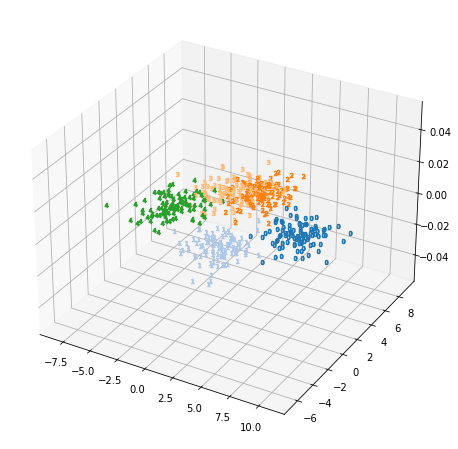

In [1070]:
drawpoints_3d(X_2d_p_data,clustering_index(best_labeling))

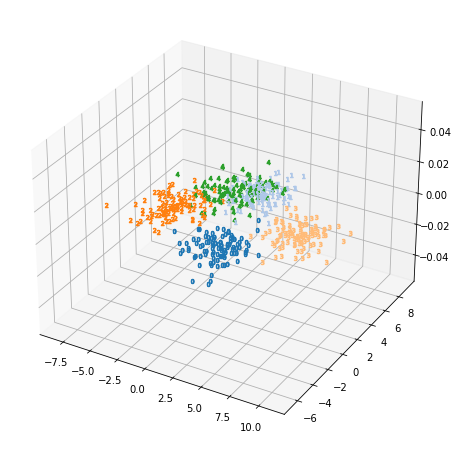

In [1071]:
kmeans_model = KMeans(n_clusters=real_cluster_number, random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,kmeans_model.labels_)

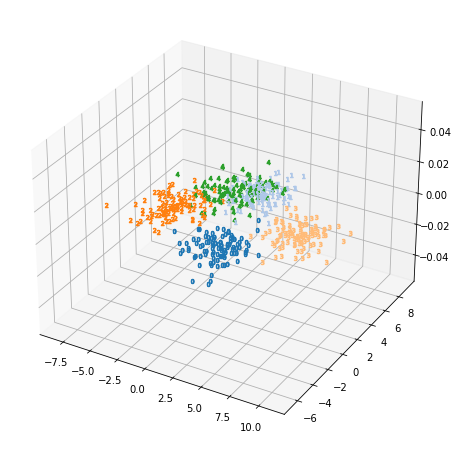

In [1072]:
gauss_model = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,gauss_model.predict(X_2d_p_data))

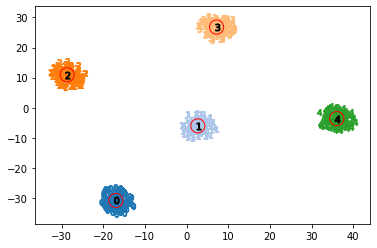

In [1073]:
points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
drawpoints_with_centers(points,clustering_index(best_labeling),best_labeling)


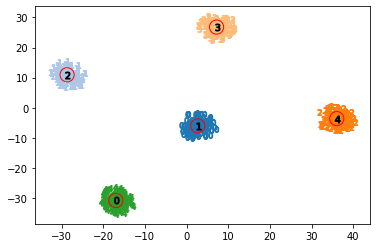

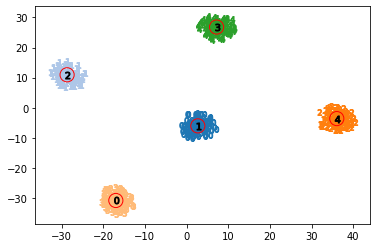

In [1074]:
kmeans_model_afterTNSE = KMeans(n_clusters=real_cluster_number, random_state=1).fit(points)
drawpoints_with_centers(points,kmeans_model_afterTNSE.labels_,best_labeling)
drawpoints_with_centers(points,kmeans_model.labels_,best_labeling)

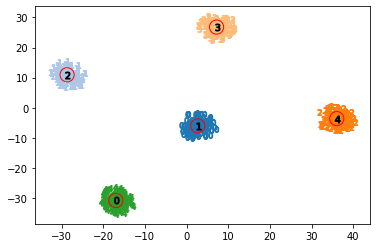

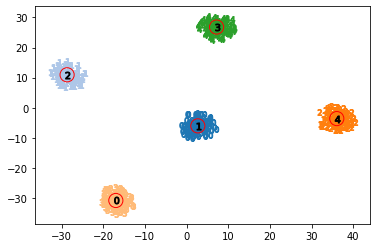

In [1075]:
gauss_model_afterTNSE  = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(points)
drawpoints_with_centers(points,gauss_model_afterTNSE.predict(points),best_labeling)
drawpoints_with_centers(points,gauss_model.predict(X_2d_p_data),best_labeling)